In [1]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, enable=True)

In [2]:
!nvidia-smi

Sat Feb  5 22:45:13 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 471.35       Driver Version: 471.35       CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
| N/A   53C    P0    22W /  N/A |    779MiB /  6144MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Data Pre-processing

### Reading the data converting into TimeSeries format

In [4]:
COLUMN_LIST_GIVEN = ['Clearsky DHI', 'Clearsky DNI', 'Clearsky GHI', 'Temperature', 'Cloud Type', 'Dew Point', 'Fill Flag', 
           'Relative Humidity', 'Solar Zenith Angle', 'Pressure', 'Precipitable Water', 'Wind Direction', 'Wind Speed']

In [5]:
def convert_ts_csv_to_df(csvfile):
    '''Take the CSV file along with the path and return dataframe'''
    df = pd.read_csv(csvfile)
    df.insert(loc=0, column='Date', 
                value=pd.to_datetime(df[['Year', 'Month', 'Day', 'Hour', 'Minute']]))
    df.drop(columns=['Year', 'Month', 'Day', 'Hour', 'Minute'], axis=1, inplace=True)
    df.set_index(keys='Date', inplace=True)
    df['Clearsky DHI'] = df['Clearsky DHI'].replace(to_replace=0, value=1)
    df['Clearsky DNI'] = df['Clearsky DNI'].replace(to_replace=0, value=1)
    df['Clearsky GHI'] = df['Clearsky GHI'].replace(to_replace=0, value=1)
    df=df[COLUMN_LIST_GIVEN]
    return df

In [6]:
training_csv = 'data/train.csv'
testing_csv = 'data/test.csv'

In [7]:
df_solar = convert_ts_csv_to_df(training_csv)
df_solar.sample(2)

,Clearsky DHI,Clearsky DNI,Clearsky GHI,Temperature,Cloud Type,Dew Point,Fill Flag,Relative Humidity,Solar Zenith Angle,Pressure,Precipitable Water,Wind Direction,Wind Speed
Date,,,,,,,,,,,,,
2015-06-08 02:00:00,1,1,1,24.0,3,20.0,0,82.17,105.08,1000,3.993,142.0,1.4
2010-12-14 16:00:00,71,959,563,1.0,0,-13.0,0,33.32,59.14,1010,0.345,323.1,4.3


In [8]:
# Reading the test dataset as Val
# Train dataset shall be split into Train and Test
# Val is read to understand the data and null values
df_solar_test = convert_ts_csv_to_df(testing_csv)
df_solar_test.sample(2)

,Clearsky DHI,Clearsky DNI,Clearsky GHI,Temperature,Cloud Type,Dew Point,Fill Flag,Relative Humidity,Solar Zenith Angle,Pressure,Precipitable Water,Wind Direction,Wind Speed
Date,,,,,,,,,,,,,
2019-02-13 18:30:00,NaN,NaN,NaN,13.8,0,2.2,0,45.36,46.14,1010,0.5,328,3.8
2019-11-19 07:00:00,NaN,NaN,NaN,6.9,0,6.9,0,99.96,154.47,1000,1.4,282,2.0


In [9]:
df_solar_test.shape

(17520, 13)

### Data Check

##### Null Check

In [10]:
df_solar.isnull().sum()

Clearsky DHI          0
Clearsky DNI          0
Clearsky GHI          0
Temperature           0
Cloud Type            0
Dew Point             0
Fill Flag             0
Relative Humidity     0
Solar Zenith Angle    0
Pressure              0
Precipitable Water    0
Wind Direction        0
Wind Speed            0
dtype: int64

In [11]:
df_solar_test.isnull().sum()

Clearsky DHI          17520
Clearsky DNI          17520
Clearsky GHI          17520
Temperature               0
Cloud Type                0
Dew Point                 0
Fill Flag                 0
Relative Humidity         0
Solar Zenith Angle        0
Pressure                  0
Precipitable Water        0
Wind Direction            0
Wind Speed                0
dtype: int64

# Feature Selection

##### Datatype Check and convert to floats for Scaling data

In [12]:
df_solar.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 175296 entries, 2009-01-01 00:00:00 to 2018-12-31 23:30:00
Data columns (total 13 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Clearsky DHI        175296 non-null  int64  
 1   Clearsky DNI        175296 non-null  int64  
 2   Clearsky GHI        175296 non-null  int64  
 3   Temperature         175296 non-null  float64
 4   Cloud Type          175296 non-null  int64  
 5   Dew Point           175296 non-null  float64
 6   Fill Flag           175296 non-null  int64  
 7   Relative Humidity   175296 non-null  float64
 8   Solar Zenith Angle  175296 non-null  float64
 9   Pressure            175296 non-null  int64  
 10  Precipitable Water  175296 non-null  float64
 11  Wind Direction      175296 non-null  float64
 12  Wind Speed          175296 non-null  float64
dtypes: float64(7), int64(6)
memory usage: 18.7 MB


In [13]:
df_solar = df_solar.astype(np.float64)

In [14]:
df_solar.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 175296 entries, 2009-01-01 00:00:00 to 2018-12-31 23:30:00
Data columns (total 13 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Clearsky DHI        175296 non-null  float64
 1   Clearsky DNI        175296 non-null  float64
 2   Clearsky GHI        175296 non-null  float64
 3   Temperature         175296 non-null  float64
 4   Cloud Type          175296 non-null  float64
 5   Dew Point           175296 non-null  float64
 6   Fill Flag           175296 non-null  float64
 7   Relative Humidity   175296 non-null  float64
 8   Solar Zenith Angle  175296 non-null  float64
 9   Pressure            175296 non-null  float64
 10  Precipitable Water  175296 non-null  float64
 11  Wind Direction      175296 non-null  float64
 12  Wind Speed          175296 non-null  float64
dtypes: float64(13)
memory usage: 18.7 MB


##### Feature update based on domain

In [15]:
print('''
Source: https://www.yellowhaze.in/solar-irradiance/
Global Horizontal Irradiance (GHI) = Direct Normal Irradiance (DNI)* cos(solar zenith angle)  +  Diffused Horizontal Irradiance (DHI)''')


Source: https://www.yellowhaze.in/solar-irradiance/
Global Horizontal Irradiance (GHI) = Direct Normal Irradiance (DNI)* cos(solar zenith angle)  +  Diffused Horizontal Irradiance (DHI)


In [16]:
df_solar['Solar Zenith Angle'].describe()

count    175296.000000
mean         89.729463
std          40.085451
min           8.550000
25%          56.450000
50%          89.860000
75%         123.060000
max         171.550000
Name: Solar Zenith Angle, dtype: float64

In [17]:
print('''This shows the Zenith Angle is given in degrees with a min or 35 and max of 171 approximately''')

This shows the Zenith Angle is given in degrees with a min or 35 and max of 171 approximately


In [18]:
from math import cos, radians

In [19]:
df_solar['Cos Zenith'] = df_solar['Solar Zenith Angle'].apply(lambda x: cos(radians(x)))

In [20]:
df_solar['Cos Zenith'].describe()

count    175296.000000
mean          0.003547
std           0.595196
min          -0.989144
25%          -0.545517
50%           0.002443
75%           0.552664
max           0.988886
Name: Cos Zenith, dtype: float64

In [21]:
df_solar.drop(columns='Solar Zenith Angle', inplace=True)

In [22]:
df_solar.sample(2)

,Clearsky DHI,Clearsky DNI,Clearsky GHI,Temperature,Cloud Type,Dew Point,Fill Flag,Relative Humidity,Pressure,Precipitable Water,Wind Direction,Wind Speed,Cos Zenith
Date,,,,,,,,,,,,,
2017-02-11 02:30:00,1.0,1.0,1.0,7.0,0.0,5.0,0.0,88.73,1010.0,1.106,160.3,1.7,-0.658427
2009-02-01 23:30:00,1.0,1.0,1.0,8.0,4.0,6.0,0.0,91.27,1010.0,1.274,203.9,1.3,-0.085243


In [23]:
df_solar.shape

(175296, 13)

### Adding the Significance of Seasonality into TS
Since we using Deep Learning, the significance of Timestamp is lost and the sinificance behaviour of data with respect to Seasonality. In order to avoid it, these parameters are added

In [24]:
# Getting the time in seconds
df_solar['ts'] = df_solar.index.map(pd.Timestamp.timestamp)
# Adding columns based on Timestamp to understand Daily and Yearly seasonality
day = 60*60*24
year = 365.2425*day

df_solar['ts_Day_sin'] = np.sin(df_solar['ts'] * (2* np.pi / day))
df_solar['ts_Day_cos'] = np.cos(df_solar['ts'] * (2 * np.pi / day))
df_solar['ts_Year_sin'] = np.sin(df_solar['ts'] * (2 * np.pi / year))
df_solar['ts_Year_cos'] = np.cos(df_solar['ts'] * (2 * np.pi / year))
df_solar.drop(columns='ts', inplace=True)
df_solar.sample(2)

,Clearsky DHI,Clearsky DNI,Clearsky GHI,Temperature,Cloud Type,Dew Point,Fill Flag,Relative Humidity,Pressure,Precipitable Water,Wind Direction,Wind Speed,Cos Zenith,ts_Day_sin,ts_Day_cos,ts_Year_sin,ts_Year_cos
Date,,,,,,,,,,,,,,,,,
2009-05-15 22:30:00,114.0,505.0,309.0,24.0,9.0,21.0,0.0,91.89,1000.0,4.205,133.5,1.7,0.386389,-0.382683,0.923880,0.724949,-0.688802
2013-09-07 03:00:00,1.0,1.0,1.0,22.0,0.0,21.0,0.0,97.12,1000.0,3.551,79.4,1.3,-0.606682,0.707107,0.707107,-0.914349,-0.404927


### Scaling of Data

In [25]:
from sklearn.preprocessing import StandardScaler

In [26]:
scalar_std_fs = StandardScaler()

##### Small trick to ensure we can perform inverse transform

In [27]:
scalar_std_fs = scalar_std_fs.fit(df_solar)

In [28]:
df_solar.shape

(175296, 17)

In [29]:
df_solar_sc = pd.DataFrame(data=scalar_std_fs.transform(df_solar), index=df_solar.index,  columns=df_solar.columns)
df_solar_sc.sample(2)

,Clearsky DHI,Clearsky DNI,Clearsky GHI,Temperature,Cloud Type,Dew Point,Fill Flag,Relative Humidity,Pressure,Precipitable Water,Wind Direction,Wind Speed,Cos Zenith,ts_Day_sin,ts_Day_cos,ts_Year_sin,ts_Year_cos
Date,,,,,,,,,,,,,,,,,
2013-03-29 13:30:00,1.417733,0.558555,0.357856,-0.924377,-0.840696,-1.044855,-0.112603,-0.048600,1.148093,-0.961704,-1.174352,-0.439092,0.706483,-0.541196,-1.306563,1.412023,0.077389
2017-10-25 17:30:00,0.649536,1.646274,1.567705,-0.029830,-0.840696,-1.532853,-0.112603,-2.344544,-0.536619,-1.200234,1.086934,1.667159,1.197312,-1.402115,-0.184592,-1.291374,0.576528


### Feature Selection

##### Any Non-linear regression model can be selected, Choose XGBoost

In [30]:
from xgboost import XGBRegressor
from xgboost import plot_importance

##### Feature Selection for Clearsky GHI since GHI constitues both DHI, DHI and Zenith Angle

In [31]:
y = df_solar_sc['Clearsky GHI']
X = df_solar_sc.drop(columns='Clearsky GHI', axis=1)

In [32]:
model_xgb = XGBRegressor(n_estimators=100)
model_xgb.fit(X, y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=12,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [33]:
model_xgb.feature_importances_

array([4.3055901e-04, 4.9750917e-03, 2.2409757e-04, 5.1668508e-06,
       5.1780359e-04, 9.5268970e-06, 8.3941568e-06, 4.2294396e-06,
       2.3650103e-03, 4.9040673e-06, 4.5308711e-06, 9.8812002e-01,
       1.4685062e-03, 1.6244006e-04, 2.7724422e-04, 1.4225190e-03],
      dtype=float32)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

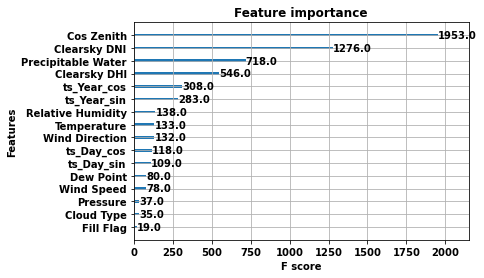

In [34]:
plot_importance(model_xgb)

### Droping not so significant columns

In [35]:
COLUMNS_DROPPED = ['Cloud Type', 'Pressure', 'Fill Flag', 'Wind Speed', 'Dew Point', 'Wind Direction', 'ts_Day_sin', 
                       'ts_Day_cos', 'Temperature', 'Relative Humidity']


In [36]:
df_solar.drop(columns=COLUMNS_DROPPED, inplace=True)
df_solar.sample(2)

,Clearsky DHI,Clearsky DNI,Clearsky GHI,Precipitable Water,Cos Zenith,ts_Year_sin,ts_Year_cos
Date,,,,,,,
2017-04-15 21:30:00,160.0,592.0,472.0,2.436,0.527401,0.970363,-0.241652
2011-07-07 00:30:00,9.0,19.0,10.0,4.371,0.034376,-0.076599,-0.997062


In [37]:
df_solar.shape

(175296, 7)

In [38]:
print('''
Precipitable Water, Cos of Zenith Angle along with time of year components are considered for further analysis
To also reduce the curse of dimensionality'''
)


Precipitable Water, Cos of Zenith Angle along with time of year components are considered for further analysis
To also reduce the curse of dimensionality


# Model Building Start

In [39]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, GRU, RepeatVector, Conv1D, BatchNormalization, MaxPooling1D, Dropout, Flatten
from tensorflow.keras.metrics import MeanSquaredError, RootMeanSquaredError
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import TimeDistributed

### Consider only last 3 years data

### Data Generation for Time Series

In [40]:
def preprocess_cvs_into_ts(csvfile):
    '''Take the CSV file along with the path and return dataframe'''
    df = pd.read_csv(csvfile)
    df.insert(loc=0, column='Date', 
                value=pd.to_datetime(df[['Year', 'Month', 'Day', 'Hour', 'Minute']]))
    df.drop(columns=['Year', 'Month', 'Day', 'Hour', 'Minute'], axis=1, inplace=True)
    df.set_index(keys='Date', inplace=True)
    
    # Updating 0 to 1 to avoid exploding gradiant problem
    # df['Clearsky DHI'] = df['Clearsky DHI'].replace(to_replace=0, value=1)
    # df['Clearsky DNI'] = df['Clearsky DNI'].replace(to_replace=0, value=1)
    # df['Clearsky GHI'] = df['Clearsky GHI'].replace(to_replace=0, value=1)
    #df=df[['Clearsky DHI', 'Clearsky DNI', 'Clearsky GHI', 'Temperature', 'Cloud Type', 'Dew Point', 'Fill Flag', 'Relative Humidity', 'Solar Zenith Angle', 'Pressure', 'Precipitable Water', 'Wind Direction', 'Wind Speed']]
    df = df[COLUMN_LIST_GIVEN]
    return df



In [41]:
# This is used to try TimeDistributed
# COLUMNS_SELECTED = ['Clearsky DHI', 'Clearsky DNI', 'Clearsky GHI']

# This is leading to nan problems
COLUMNS_SELECTED = ['Clearsky DHI', 'Clearsky DNI', 'Clearsky GHI', 'Cos Zenith', 
                    'Precipitable Water', 'ts_Year_sin', 'ts_Year_cos']



In [42]:
def preprocess_ts_features(df):
    '''This shall ensure the time series features are added and 
    non-significant features are removed'''
    
    # Cos of Zenith angle contributes GHI
    df['Cos Zenith'] = np.cos(np.deg2rad(df['Solar Zenith Angle']))
    
    # Adding the time series features into the dataset for Seasonality
    sec_in_day = 60*60*24
    sec_in_year = 365.2425*sec_in_day
    df['ts'] = df.index.map(pd.Timestamp.timestamp)
    df['ts_Day_sin'] = np.sin(df['ts'] * (2* np.pi / sec_in_day))
    df['ts_Day_cos'] = np.cos(df['ts'] * (2 * np.pi / sec_in_day))
    df['ts_Year_sin'] = np.sin(df['ts'] * (2 * np.pi / sec_in_year))
    df['ts_Year_cos'] = np.cos(df['ts'] * (2 * np.pi / sec_in_year))
    
    # Ordering only the selected Columns in a proper order for further processing
    df = df[COLUMNS_SELECTED]
    return df

In [43]:
df_solar = preprocess_cvs_into_ts(training_csv)
df_solar = preprocess_ts_features(df_solar)
df_solar.sample(2)

,Clearsky DHI,Clearsky DNI,Clearsky GHI,Cos Zenith,Precipitable Water,ts_Year_sin,ts_Year_cos
Date,,,,,,,
2017-10-22 17:00:00,92,901,747,0.726575,2.802,-0.933129,0.359542
2013-09-13 21:00:00,165,567,478,0.551646,4.865,-0.955106,-0.296265


In [44]:
df_solar.shape

(175296, 7)

##### Scaling the data

In [45]:
from sklearn.preprocessing import StandardScaler
scalar_std_ts = StandardScaler()

In [46]:
scalar_std_ts = scalar_std_ts.fit(df_solar)
solar_data_sc = scalar_std_ts.transform(df_solar)
df_solar_data = pd.DataFrame(data=solar_data_sc, index=df_solar.index, columns=df_solar.columns)
solar_data_sc.shape

(175296, 7)

##### Data Generation
1. Take the values of Dataframe for a given batch length and Predict the values of 'Clearsky DHI', 'Clearsky DNI', 'Clearsky GHI' for the next row.
2. Move the series by 1 row, repeat step 1

In [47]:
# Daily there around 48 observations
# Weekly there are around 48*7 = 336 observations
# Monthly there are around 48*30 = 1440 observations
# Yearly there are around 48*365 = 17520 observations

# Ensuring the that total length is not more than 3 years since the model training is taking lot of time
# Also to handle out of memory issues
total_data_len = solar_data_sc.shape[0]
if solar_data_sc.shape[0] > 17520*3:
    total_data_len = 17520*3
else:
    total_data_len = solar_data_sc.shape[0]

batch_input_len = 48
batch_output_len = 1
features_len = 7
# train_data_start = total_data_len - batch_input_len*4
train_data_start = total_data_len
print(f'''
The total length of input {total_data_len} and the batch length is {batch_input_len} with features {features_len}
The training start {train_data_start}''')


The total length of input 52560 and the batch length is 48 with features 7
The training start 52560


In [48]:
def ts_data_generator(data_arr, batch_len):
    X = []
    y = []
    for i in range(len(data_arr)-batch_len):
        X_rows = [row for row in data_arr[i:i+batch_len]]
        X.append(X_rows)
        y_row = [data_arr[i+batch_len][0],data_arr[i+batch_len][1], data_arr[i+batch_len][2]]
        y.append(y_row)
    return np.array(X), np.array(y)

In [49]:
X, y = ts_data_generator(solar_data_sc[-train_data_start:], batch_input_len)

##### Split the train csv data into train and val

In [50]:
train_split = np.int(X.shape[0]*0.7)

X_train, y_train = X[:train_split], y[:train_split]
X_val, y_val = X[train_split:], y[train_split:]

X_train.shape, y_train.shape, X_val.shape, y_val.shape

((36758, 48, 7), (36758, 3), (15754, 48, 7), (15754, 3))

### Build the Model

In [51]:
input_shape = (batch_input_len, features_len)
learning_rate = 0.0001

In [52]:
def build_GRU_trans1(input_shape, lr):
    l0 = Input(shape=input_shape)

    l1 = GRU(units=128, activation='relu', recurrent_dropout=.3)(l0)
#     l1 = RepeatVector(input_shape[1])(l1)
#     l1 = GRU(units=16, activation='relu', recurrent_dropout=.2)(l1)
    l1 = Flatten()(l1)
#     y = Dense(units=10, activation='relu')(l1)
    y = Dense(units=3, activation='linear')(l1)

    model = Model(inputs=l0, outputs=y)
    
    model.compile(optimizer=Adam(learning_rate=lr), 
                    loss=MeanSquaredError(),
                   metrics=[MeanSquaredError()])
    return model

In [53]:
def build_LSTM1(input_shape, lr):
    l0 = Input(shape=input_shape)

    # l1 = LSTM(units=128, activation='tanh', recurrent_dropout=.3, kernel_initializer='he_normal')(l0)
    
    l1 = LSTM(units=64, activation='tanh', recurrent_dropout=.3, return_sequences=True, kernel_initializer='glorot_uniform')(l0)
    l1 = LSTM(units=64, activation='tanh', recurrent_dropout=.3)(l1)
    
    # y = Dense(units=10, activation='tanh')(l1)
    # y = Dropout(rate=.3)(y)
    y = Dense(units=3)(l1)

    model = Model(inputs=l0, outputs=y)
    
    model.compile(optimizer=Adam(learning_rate=lr), 
                    loss=MeanSquaredError(),
                   metrics=[MeanSquaredError()])
    return model

In [54]:
def build_LSTM_trans1(input_shape, lr):
    l0 = Input(shape=input_shape)

    l1 = LSTM(units=128, activation='relu', recurrent_dropout=.2, return_sequences=True)(l0)
    l1 = LSTM(units=64, activation='relu', recurrent_dropout=.2)(l0)
    
    l2 = RepeatVector(input_shape[1])(l1)
    
    l3 = LSTM(units=64, activation='relu', recurrent_dropout=.2, return_sequences=True)(l2)
    l3 = LSTM(units=128, activation='relu', recurrent_dropout=.2)(l3)

    y = Dense(units=10, activation='relu')(l3)
    y = Dense(units=3, activation='linear')(y)

    model = Model(inputs=l0, outputs=y)
    
    model.compile(optimizer=Adam(learning_rate=lr), 
                    loss=MeanSquaredError(),
                   metrics=[MeanSquaredError()])
    return model

In [55]:
# n_timesteps, n_features, n_outputs = X_train.shape[0], X_train[1], X_train[2]

def build_Conv_trans1(input_shape, lr):
    # l0 = Input(shape=input_shape)
    model = Sequential()
    model.add(TimeDistributed(Conv1D(filters=48, kernel_size=3, activation='relu', padding='same', 
                                kernel_initializer='he_normal', input_shape=X_train.shape)))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(Conv1D(filters=48, kernel_size=3, activation='relu', padding='same', kernel_initializer='he_normal')))
    model.add(TimeDistributed(Flatten()))
    model.add(Dense(units=3, activation='linear'))
    
#     l1 =     # l1 = TimeDistributed(BatchNormalization())(l1)
#     l1 = TimeDistributed(Conv1D(filters=48, kernel_size=3, activation='relu', padding='same', 
#                                 kernel_initializer='he_normal'))(l1)
#     l1 = TimeDistributed(Flatten())(l1)
#     #     l2 = Dropout(rate=.3)(l1)
#     #     #l2 = RepeatVector(input_shape[1])(l1)
    
#     #     l3 = Conv1D(filters=8, kernel_size=3, activation='relu')(l2)
#     #     l3 = BatchNormalization()(l3)
#     #     l3 = Conv1D(filters=16, kernel_size=3, activation='relu')(l1)
    
#     y = TimeDistributed(Dense(units=10, activation='relu'))(l1)
#     y = TimeDistributed(Dropout(rate=0.3))(y)
#     y = Dense(units=3, activation='linear')(y)

#     model = Model(inputs=l0, outputs=y)
    
    model.compile(optimizer=Adam(learning_rate=0.001), 
                    loss=MeanSquaredError(),
                   metrics=[MeanSquaredError()])
    return model

In [56]:
def train_model(model_name):
    if model_name == 'GRU':
        model = build_GRU_trans1(input_shape, learning_rate)
    elif model_name == 'LSTM':
        model = build_LSTM_trans1(input_shape, learning_rate)
    elif model_name == 'LSTM_linear':
        model = build_LSTM1(input_shape, learning_rate)
    else:
        model = build_Conv_trans1(input_shape, learning_rate)
    
    # model.summary()
    # Check points for Early stopping and Saving the best model
    cb_earlystop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=200)
    cb_modelcp = ModelCheckpoint('best_model1.h5', monitor='val_mean_squared_error', 
                                 mode='min', verbose=1, save_best_only=True)

    # Fit the model

    model_hist = model.fit(X_train, y_train, validation_data=(X_val, y_val), 
                           epochs=10, callbacks=[cb_earlystop, cb_modelcp])
    model.summary()
    return model

In [57]:
# # model_name = 'LSTM' 
# # model_name = 'GRU' 
# model_name = 'CONV' 
# model = train_model(model_name)

In [58]:
# model_name = 'LSTM' 
# # model_name = 'GRU' 
# # model_name = 'CONV' 
# model = train_model(model_name)

In [59]:
# # model_name = 'LSTM' 
# model_name = 'GRU' 
# # model_name = 'CONV' 
# model = train_model(model_name)

In [60]:
model_name = 'LSTM_linear' 
# model_name = 'GRU' 
# model_name = 'CONV' 
model = train_model(model_name)

Epoch 1/10
1149/1149 [==============================] - 348s 299ms/step - loss: 0.1213 - mean_squared_error: 0.1212 - val_loss: 0.0159 - val_mean_squared_error: 0.0159

Epoch 00001: val_mean_squared_error improved from inf to 0.01588, saving model to best_model1.h5
Epoch 2/10
1149/1149 [==============================] - 339s 295ms/step - loss: 0.0217 - mean_squared_error: 0.0217 - val_loss: 0.0099 - val_mean_squared_error: 0.0099

Epoch 00002: val_mean_squared_error improved from 0.01588 to 0.00988, saving model to best_model1.h5
Epoch 3/10
1149/1149 [==============================] - 343s 298ms/step - loss: 0.0162 - mean_squared_error: 0.0162 - val_loss: 0.0089 - val_mean_squared_error: 0.0089

Epoch 00003: val_mean_squared_error improved from 0.00988 to 0.00885, saving model to best_model1.h5
Epoch 4/10
1149/1149 [==============================] - 341s 296ms/step - loss: 0.0126 - mean_squared_error: 0.0126 - val_loss: 0.0058 - val_mean_squared_error: 0.0058

Epoch 00004: val_mean_squ

In [61]:
model.load_weights('best_model1.h5')

In [62]:
def plot_model_history(model):
    mod_hist = model.history
    plt.subplot(1, 2, 1)
    plt.plot(mod_hist.history['loss'])
    plt.plot(mod_hist.history['val_loss'])
    plt.title('Loss MSE')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend(loc='best')
    plt.subplot(1, 2, 2)
    plt.plot(mod_hist.history['mean_squared_error'])
    plt.plot(mod_hist.history['val_mean_squared_error'])
    plt.title('Error RMSE')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend(loc='best')
    

No handles with labels found to put in legend.
No handles with labels found to put in legend.


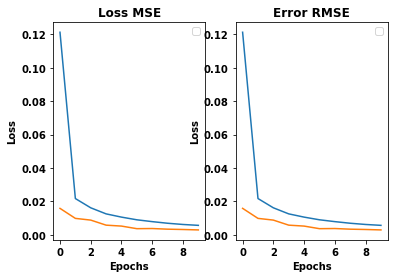

In [63]:
plot_model_history(model=model)

### Predict

In [64]:
def ts_data_pred_generator(data_arr, batch_input_len, iter_cnt):
    X = [row for row in data_arr[iter_cnt: iter_cnt+batch_input_len]]
    y = [data_arr[batch_input_len+iter_cnt][0], data_arr[batch_input_len+iter_cnt][1], data_arr[batch_input_len+iter_cnt][2]]
    return np.array(X), np.array(y)

In [65]:
def create_df_predict(training_csv, testing_csv, batch_input_len):
    df_train = preprocess_cvs_into_ts(training_csv)
    df_train = preprocess_ts_features(df_train)
    df_test = preprocess_cvs_into_ts(testing_csv)
    df_test = preprocess_ts_features(df_test)
    test_len = df_test.shape[0]
    df_pred = pd.concat([df_train, df_test], axis=0)
    df_pred.fillna(0)
    return df_pred[-(test_len+batch_input_len):]

##### Debugging Start

In [66]:
# # Creating train (with batch length) and test dataset
# df_solar_pred = create_df_predict(training_csv, testing_csv, batch_input_len)

# # Scaling for data
# solar_data_pred_sc = scalar_std_ts.transform(df_solar_pred)

# # Used only for testing
# cnt = 0

# # Contains the predicted output
# x_pred = []

# tst_len = solar_data_pred_sc.shape[0] - batch_input_len

In [67]:
# tst_len

In [68]:
# i = 0
# X_test, y_test = ts_data_pred_generator(solar_data_pred_sc, batch_input_len, i)

In [69]:
# X_test, y_test

In [70]:
# X_i = np.expand_dims(X_test, axis=0)
# X_i

In [71]:
# y_i = model.predict(X_i)
# y_i

In [72]:
# solar_data_pred_sc[batch_input_len+i][0:3]

In [73]:
# solar_data_pred_sc[batch_input_len+i][0:3] = y_i

In [74]:
# solar_data_pred_sc[batch_input_len+i][0:3]

In [75]:
# np.hstack([y_i[0], solar_data_pred_sc[batch_input_len+i][3:]])

In [76]:
# solar_data_pred_sc[batch_input_len+i]

In [77]:
# i = 1
# X_test, y_test = ts_data_pred_generator(solar_data_pred_sc, batch_input_len, i)

In [78]:
# X_test, y_test

In [79]:
# X_i = np.expand_dims(X_test, axis=0)
# X_i

In [80]:
# y_i = model.predict(X_i)
# y_i

##### Debugg End

In [81]:
def model_predict(training_csv, testing_csv, batch_input_len, model):
    '''This method takes the test csv file, gives the output as predicted array
    Creating df which will contain last rows from train which equal to the length of the batch
    append those to the test.
    The first prediction for the test row 0 shall consider data from train and predict the 0 row of test
    the predictions are updated into test first row and then prediction is done for the 1 row in test
    this loop repeats'''
    
    # Creating train (with batch length) and test dataset
    df_solar_pred = create_df_predict(training_csv, testing_csv, batch_input_len)
    
    # Scaling for data
    solar_data_pred_sc = scalar_std_ts.transform(df_solar_pred)
    
    # Used only for testing
    cnt = 0
    
    # Contains the predicted output
    x_pred = []
    
    tst_len = solar_data_pred_sc.shape[0] - batch_input_len
    
    # Runs for the entire X test
    for i in range(tst_len):
        # Tranforming the data into X and y to pass it NN predict
        X_test, y_test = ts_data_pred_generator(solar_data_pred_sc, batch_input_len, i)
    
    
        # Since only one value of (batchlength, features) is passed 
        # it needs to be in the format (n, l, f)
        X_i = np.expand_dims(X_test, axis=0)
        # print('X_i[-1]\n', X_i[0][-1])
        
        # Predicts the next row 'Clearsky DHI', 'Clearsky DNI', 'Clearsky GHI'
        y_i = model.predict(X_i)
        
        # Update predicted 'Clearsky DHI', 'Clearsky DNI', 'Clearsky GHI' since they are not passed
        solar_data_pred_sc[batch_input_len+i][0:3] = y_i
        
        if i % 100==0:
            print(f'{i}={y_i}', end=', ')
        
        
    # print('x_i_pred\n', x_i_pred)
    # This trick is used to ensure we are inverse transform. 
    # Inverse transform needs the same length features which was used for fit/transform
    return scalar_std_ts.inverse_transform(solar_data_pred_sc)

##### Debuggin end

In [82]:
X_pred = model_predict(training_csv, testing_csv, batch_input_len, model)

0=[[-0.8700357  -0.914776   -0.79084736]], 100=[[-0.83494794 -0.89210004 -0.7732969 ]], 200=[[-0.8357271 -0.8937662 -0.7762095]], 300=[[-0.8311229  -0.89187884 -0.7800877 ]], 400=[[-0.8302024  -0.8901792  -0.78296125]], 500=[[-0.8292327  -0.905951   -0.77448446]], 600=[[-0.8144113  -0.9474208  -0.78369135]], 700=[[ 0.15205315  0.9277597  -0.05842497]], 800=[[0.5638522 1.4882185 0.900583 ]], 900=[[1.1908736 1.2121516 1.0926486]], 1000=[[0.47388333 1.4220681  0.7613785 ]], 1100=[[ 0.06884206  0.21106839 -0.42302728]], 1200=[[-0.8607273  -0.94911665 -0.80120933]], 1300=[[-0.8287423  -0.89241964 -0.77793056]], 1400=[[-0.83673835 -0.8951402  -0.7787283 ]], 1500=[[-0.8352716  -0.89286107 -0.78494334]], 1600=[[-0.8372196  -0.8855552  -0.78737456]], 1700=[[-0.84013915 -0.9065891  -0.77345675]], 1800=[[-0.8139256  -0.9623305  -0.78029746]], 1900=[[0.37611216 0.9537494  0.10478922]], 2000=[[1.2453245 1.2002333 1.0858859]], 2100=[[0.6352224 1.7636474 1.6633373]], 2200=[[1.569703  0.926656  0.9017

In [83]:
def generate_pred_outputfile(X_pred):
    '''This shall generate the output files for submission'''
    # est_period=48*365
    est_period=len(X_pred)
    start_datetime = "2019-01-01 00:00:00"
    pred_indx = pd.date_range(start=start_datetime, periods=est_period, freq="30T")
    y_pred_const = []
    for i in range(len(X_pred)):
        y_pred_const.append(X_pred[i][0:3])

    df_y_pred = pd.DataFrame(data=y_pred_const, index=pred_indx, columns=['Clearsky DHI', 'Clearsky DNI', 'Clearsky GHI'])
    df_X_pred = pd.DataFrame(data=X_pred, index=pred_indx, columns=['Clearsky DHI', 'Clearsky DNI', 'Clearsky GHI', 
                                                               'Solar Zenith Angle', 
                                                               'Precipitable Water', 'ts_Year_sin', 'ts_Year_cos'])
    df_y_pred.to_csv('submission_y_AnilKagita.csv', index=False)
    df_y_pred.to_csv('verify_y_AnilKagita.csv', index=True)
    df_X_pred.to_csv('verify_x_AnilKagita.csv', index=True)
    return df_y_pred, df_X_pred

In [84]:
df_y_pred, df_X_pred = generate_pred_outputfile(X_pred)

In [85]:
def plot_pred_y(df_y_pred):
    plt.figure(figsize=(12, 9))
    cnt = 1
    for col in df_y_pred.columns:
        plt.subplot(3, 1, cnt)
        plt.title(col)
        plt.plot(df_y_pred[col], label=col)
        plt.xticks(rotation=45)
        plt.legend(loc='best')
        cnt += 1

    plt.tight_layout()
    plt.show()

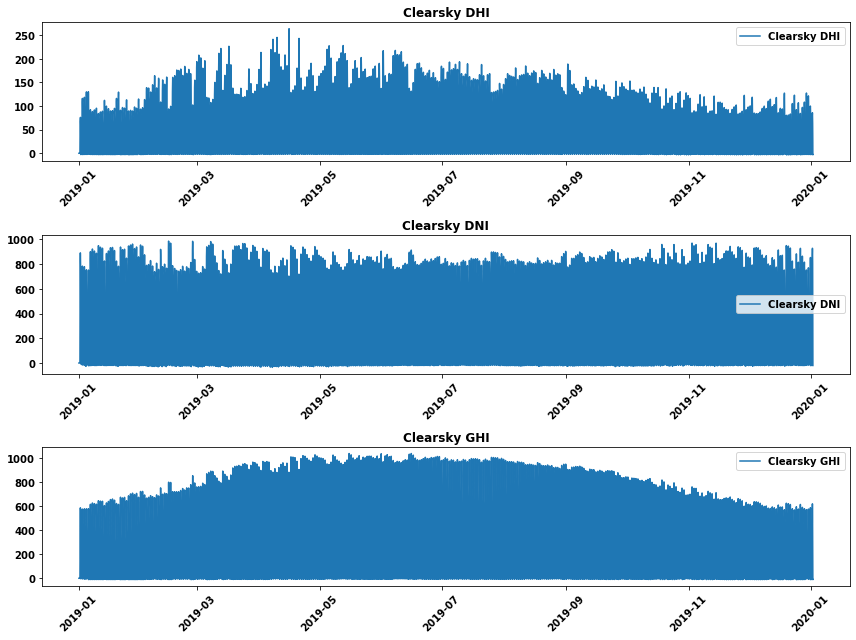

In [86]:
plot_pred_y(df_y_pred)

In [87]:
def plot_train_test(df_train_plot, df_test_plot):
    plt.figure(figsize=(12, 9))
    cnt = 1
    for col in df_y_pred.columns:
        plt.subplot(3, 1, cnt)
        plt.title(col)
        plt.plot(df_train_plot[col], label='train')
        plt.plot(df_test_plot[col], label='test')
        plt.xticks(rotation=45)
        plt.legend(loc='best')
        cnt += 1

    plt.tight_layout()
    plt.show()

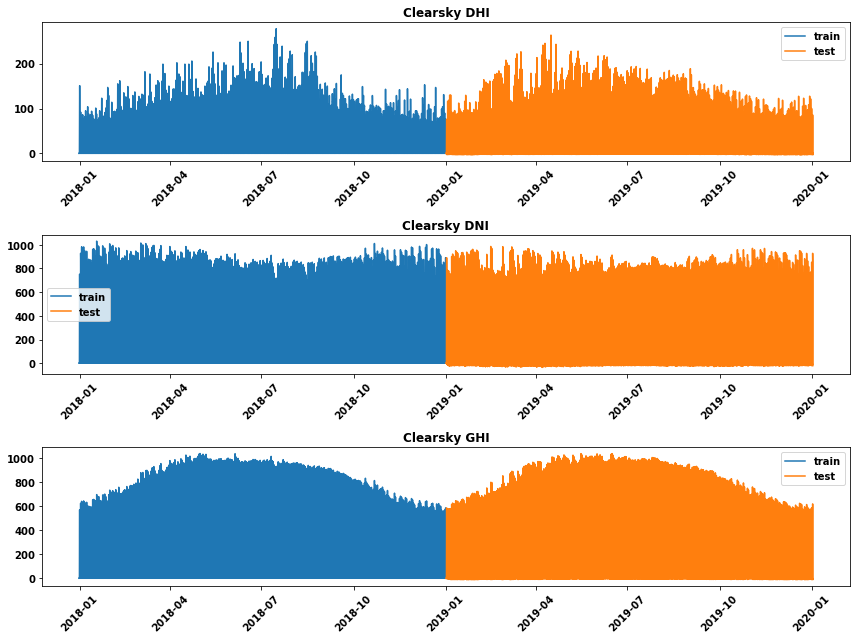

In [88]:
plot_train_test(df_solar[['Clearsky DHI', 'Clearsky DNI', 'Clearsky GHI']][-len(X_pred):], df_y_pred)